Define function to access instagram graph api. To implement the functions I followed the article  https://medium.com/@ritikkhndelwal/instagram-hashtag-search-using-python-and-instagram-graph-api-a5efc2dce6f1 and adapted the given functions to my case. Nevertheless I tried also extensively the instagram graph api and read the doucmentation for it to discover the restirictions and what data I can get. For example I could not get with the business covery endpoint any data foro hastags.

In [16]:
import requests
import re 
# access token can be used till february 2024
access_token = "EAAKb83xTK40BO7gBDVcd3GoFsLMwJFEv1MrkbdbqpTKOVeA2a0GuZCnusq2SuGeD4IG2GjbeEV5OkV4dzHEN53KTRoDgnsKlsPLAIkuo2Yz7zdtEYRl3IvM4mHct3e6syQu0MjKt4wq3FViWZBkms1jGhxbFmOe8ZALYRQNfOBTOs4wH9I5v4kC"
instagram_account_id = 17841402187545471


graph_url = 'https://graph.facebook.com/v18.0/'
def get_hashtag_id(hashtag = '',instagram_account_id = '',access_token = ''):
    url = graph_url + 'ig_hashtag_search'
    param = dict()
    param['user_id'] = instagram_account_id
    param['q'] = hashtag
    param['access_token'] = access_token
    response = requests.get(url,param)
    response = response.json()
    hashtag_id = response['data'][0]['id']
    return hashtag_id

# retrieve name and id for a hasthag
def get_data_of_hashtag(hashtag_id = '',access_token=''):
    url = graph_url + hashtag_id
    param =dict()
    param['access_token'] = access_token
    param['fields'] = 'id,name'
    response = requests.get(url,param)
    response = response.json()
    return response

# recent media for a hashtag
def get_recent_media(hashtag_id='',access_token = '',instagram_account_id = ''):
    url = graph_url + hashtag_id + '/recent_media'
    param = dict()
    param['access_token'] = access_token
    param['user_id'] = instagram_account_id
    param['fields'] = 'caption,like_count,permalink,timestamp,media_type'
    response = requests.get(url, param,timeout=90)
    response = response.json()
    print(response)
    return response

def get_top_media(hashtag_id='',access_token='',instagram_account_id=''):
    url = graph_url + hashtag_id + '/top_media'
    param = dict()
    param['access_token'] = access_token
    param['user_id'] = instagram_account_id
    param['fields'] = 'caption,like_count,permalink'
    response = requests.get(url, param)
    response = response.json()
    print(response)
    return response

We will use mango db for a variety of advantages First I want to put focus on flexiblity and scalability. The Database will not be complex also, so not need complex queries with joins, which would favor relational database technologies like postgresql.

In [64]:
from pymongo import MongoClient
import json

client = MongoClient('localhost', 27017)

# let's get the list of DBs already defined
print(client.list_database_names())


['admin', 'config', 'local']


In [65]:
# let's create a new DB - bda
database = client['bda']

# let's create a collection
posts = database.posts

Grap the messages for the last 24 hours for the hashtags FreePalestine and proisrael. Two of the most popular hashtags in the isreal plästina war. With it we can look what hastasgs are occuring most often in the las 24 hours and determine our hashtags to use.

In [57]:
hashtag_id = '17841562354125930'
data = []
count = 0
recent = get_recent_media(hashtag_id, access_token,instagram_account_id)
data = [] + recent["data"]
while True:
    if not ( 'paging' in recent and 'next' in recent['paging']):
        break
    count = count + 1
    try:
        response = requests.get(recent['paging']['next'] ,timeout=60)
        recent = response.json()
        # we saw that sometimes there is at the last pages not data returned, but urls for new pages
        if'data'not in recent:
            break
        print(recent['data'][0]['timestamp'])
        data = data + recent['data']
    except requests.exceptions.Timeout:
        print("Timeout")
        print(recent)
        break
    except: #code to run if error occurs
        print("caught_it")
        print(recent)

{'data': [{'caption': 'In sha Allah 💗 #freepalestine #freegaza #inda #allhamdulillah❤️ #instagram', 'like_count': 0, 'permalink': 'https://www.instagram.com/reel/C1R6QD5r3TG/', 'timestamp': '2023-12-25T14:47:39+0000', 'media_type': 'VIDEO', 'id': '18081884173419721'}, {'caption': '仕事帰りに、なんばでのスタンディングに混ぜてもらった。なんばの何にもない広場から、心斎橋筋商店街まで移動しつつ結構な人数が立っていたよ。\n\n初めましての人も、どこかのなにかのスタンディングで顔を見たことがあるという方もいて、いろんな人とお話しできて嬉しかった。\n\nお若い女の子に、これはどこの国の旗？って聞かれたり、\nファイティン！って声かけてくれたりサムアップして通る人もいた。\n\nフラッグもらっちゃった🇵🇸\n\n年内停戦だよ。頼むよ。\nもうこれ以上人を殺さないで。\n\n#FreePalestine \n#StopGenocide\n#CeasefireNOW', 'like_count': 0, 'permalink': 'https://www.instagram.com/p/C1R6gCFywIW/', 'timestamp': '2023-12-25T14:47:38+0000', 'media_type': 'CAROUSEL_ALBUM', 'id': '17844855603124293'}, {'caption': '🍉 #standwithpalestine 🇵🇸 #freepalestine #savepalestine #childrenofpalestine #ceasefirenow #stopgazagenocide #palestinianholocaust #ethniccleansing #depopulationagenda #landgrab #oilandgas #zionists #khazarianmafia✡️ #synagogueofsatan👹 

In [59]:
from collections import Counter
import matplotlib.pyplot as plt

overall = []
for post in data:
    if "caption" in post:
        hashtags = hashtags_inlcuded_In_text(post['caption'])
        overall = overall + hashtags

counts_of_unique = Counter(overall)

# Sort items based on counts in descending order
sorted_items = sorted(counts_of_unique.items(), key=lambda x: x[1], reverse=True)

top_items = sorted_items[:20]
top_items

# Extract items and their counts for plotting
items, counts = zip(*top_items)

# Plotting the bar chart
plt.bar(items, counts, color='blue')
plt.xlabel('Unique Items')
plt.ylabel('Count')
plt.title('Count of Unique Items')
plt.xticks(rotation=45, ha='right')
plt.show()

In [60]:
top_items = sorted_items[:20]
top_items


[('#freepalestine', 28992),
 ('#palestine', 9098),
 ('#gaza', 6192),
 ('#ceasefirenow', 5388),
 ('#savepalestine', 4044),
 ('#FreePalestine', 3452),
 ('#gazaunderattack', 3069),
 ('#islam', 2820),
 ('#savegaza', 2514),
 ('#freegaza', 2488),
 ('#istandwithpalestine', 2053),
 ('#muslim', 2045),
 ('#palestinewillbefree', 2043),
 ('#israel', 2030),
 ('#fyp', 1661),
 ('#genocide', 1606),
 ('#palestina', 1493),
 ('#viral', 1360),
 ('#ceasefire', 1325),
 ('#allah', 1321)]

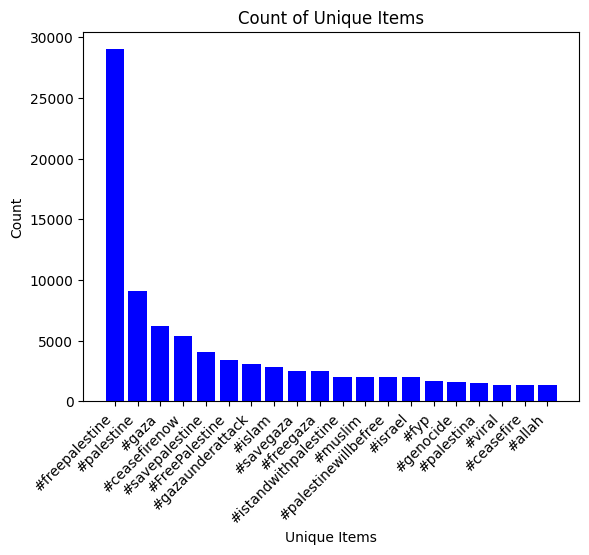

In [61]:
# Extract items and their counts for plotting
items, counts = zip(*top_items)

# Plotting the bar chart
plt.bar(items, counts, color='blue')
plt.xlabel('Unique Items')
plt.ylabel('Count')
plt.title('Count of Unique Items')
plt.xticks(rotation=45, ha='right')
plt.show()

In [68]:

len(data)


28564

In [69]:
result = posts.insert_many(data)


In [71]:
posts.count_documents({})

28564

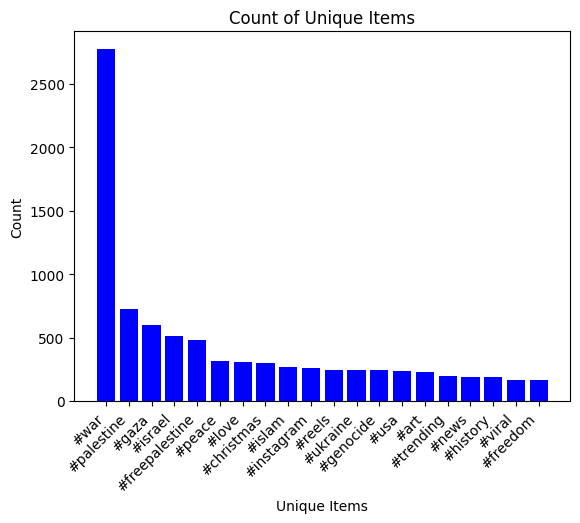

In [56]:
# we excuted aslo every thing also for the hashtag war, to get an first impression of how important palestine war is
items, counts = zip(*top_items)

# Plotting the bar chart
plt.bar(items, counts, color='blue')
plt.xlabel('Unique Items')
plt.ylabel('Count')
plt.title('Count of Unique Items')
plt.xticks(rotation=45, ha='right')
plt.show()


In [20]:
def hashtags_inlcuded_In_text(text):
    hashtags = re.findall(r'#\w+', text)
    return hashtags

In [58]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("VADER is smart, handsome, and funny.")



{'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}

In [6]:
def get_all_posts_since_24hours(hashtag_names, access_token, instagram_account_id):
    hashtag_ids = []
    for name in hashtag_names:
        hashtag_ids.append(get_hashtag_id(name,instagram_account_id,access_token))
    
    return hashtag_ids


    


In [7]:
get_all_posts_since_24hours(['FreePalestine','BringThemHomeNow'],access_token,instagram_account_id)



['17841562354125930', '17841531883073197']

I searched after the popularst hastags for the palätina isreal war. So I have searched 5 different hastags for the palästina side and 5 for isreal. For the palästina side I fount the hashtags #FreePalestine, #palistina, #savepalestine, #alquds (the holy city), gazaunderattack, #palestinewillbefree, #palastine. For the isreal side I have : #IsraelUnderAttack, #FreeIsrael, #israel, #proisrael (30000), #standwithisreal, #BringThemHomeNow. I will put all posts in one collection into a mongodb database.

In [ ]:
hashtags_for_palästina = ['FreePalestine','palistina', 'savepalestine', 'alquds', 'gazaunderattack', 'palestinewillbefree','gaza']
hashtags_for_isreal = ['IsraelUnderAttack', 'FreeIsrael', 'israel', 'proisrael', 'standwithisreal', 'BringThemHomeNow','prayforisrael']

# First retrieve the hashtag ids and also look up if they are 


In [ ]:
# load the data
adults_list = list(data.values())
result = adults.insert_many(adults_list)
adults.count_documents({})